In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy import stats
from scipy.stats import bootstrap
import bayes_toolbox.glm as bg
import arviz as az
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Set some defaults
sns.set_theme(context="paper", font_scale=1.2)
sns.set_style("ticks")
plt.rcParams["mathtext.default"] = "regular"
plt.rc("axes.spines", top=False, right=False)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv("../results/ige_ege_jump.csv")
df["adaptation"] = np.nan
df["total error"] = np.nan
df.columns

Index(['si', 'SN', 'id', 'tester', 'TN', 'move_cycle', 'hX', 'hY', 'rot_hX',
       'rot_hY', 'rotation', 'tgt_jump', 'hand_max_dist', 'radvelmax', 'tgtX',
       'tgtY', 'rot_hand_theta', 'theta_maxradv', 'raw_ep_hand_ang', 'tgt_ang',
       'tgt_dist', 'fbi', 'MT', 'RT', 'ST', 'adaptation', 'total error'],
      dtype='object')

In [3]:
df.head()

si  SN    id tester  TN  move_cycle        hX         hY  rot_hX  rot_hY  \
0   1   1  01_i      s   1           1  2.556301  88.878669     0.0     0.0   
1   1   1  01_i      s   2           2  3.566301  88.868669     0.0     0.0   
2   1   1  01_i      s   3           3  3.686301  94.458669     0.0     0.0   
3   1   1  01_i      s   4           4  2.756301  89.038669     0.0     0.0   
4   1   1  01_i      s   5           5  2.666301  86.048669     0.0     0.0   

   ...  theta_maxradv  raw_ep_hand_ang  tgt_ang  tgt_dist  fbi        MT  \
0  ...       6.199063        91.647469       90        90    1  0.622884   
1  ...       4.738781        92.298047       90        90    1  0.508572   
2  ...      -1.422603        92.234865       90        90    1  0.255398   
3  ...      -0.279086        91.773095       90        90    1  0.396111   
4  ...      -3.255367        91.774797       90        90    1  0.275479   

          RT        ST  adaptation  total error  
0  10.843442  5.611307         NaN          NaN  
1   0.882459  1.620206         NaN          NaN  
2   2.651180  1.312924         NaN          NaN  
3   0.398744  1.336725         NaN          NaN  
4   0.419456  1.269343         NaN          NaN  

[5 rows x 27 columns]

In [4]:
# Outlier removal
z_thresh = 3.5

# z-score hand angle data
df["theta_maxradv_z"] = df.groupby("SN")["theta_maxradv"].transform(stats.zscore)

# Create outlier column
df["theta_maxradv_outlier"] = np.abs(df["theta_maxradv_z"]) > z_thresh

# Calculate within-subject mean using non-outlier trials only
df["theta_maxradv_mean"] = df[np.abs(df["theta_maxradv_z"]) <= z_thresh].groupby("SN")["theta_maxradv"].transform(np.mean)

# Replace outliers with within-subject mean values
df["theta_maxradv_mean"] = df.groupby("SN")["theta_maxradv_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

## Create final column with "cleaned" hand angles OR replace outliers with NaNs
# df["theta_maxradv_clean"] = np.where(np.abs(df["theta_maxradv_z"]) > z_thresh,
#                                      df["theta_maxradv_mean"],
#                                      df["theta_maxradv"])
df["theta_maxradv_clean"] = np.where(np.abs(df["theta_maxradv_z"]) > z_thresh,
                                     np.nan,
                                     df["theta_maxradv"])

# z-score movement extent data
df["hand_max_dist_z"] = df.groupby("SN")["hand_max_dist"].transform(stats.zscore)

# Create outlier column
df["hand_max_dist_outlier"] = (np.abs(df["hand_max_dist_z"]) > z_thresh) | (df["hY"] < 0)

# Calculate within-subject mean using non-outlier trials only
df["hand_max_dist_mean"] = df[np.abs(df["hand_max_dist_z"]) <= z_thresh].groupby("SN")["hand_max_dist"].transform(np.mean)

# Replace outliers with within-subject mean values
df["hand_max_dist_mean"] = df.groupby("SN")["hand_max_dist_mean"].transform(lambda x: x.fillna(np.nanmean(x)))

## Create final column with "cleaned" hand angles OR replace outliers with NaNs
# df["hand_max_dist_clean"] = np.where(np.abs(df["hand_max_dist_z"]) > z_thresh,
#                                      df["hand_max_dist_mean"],
#                                      df["hand_max_dist"])
df["hand_max_dist_clean"] = np.where(np.abs(df["hand_max_dist_z"]) > z_thresh,
                                     np.nan,
                                     df["hand_max_dist"])


In [5]:
# Count number of outliers per participant
num_outliers_angle = df.groupby("SN")["theta_maxradv_outlier"].sum()
print(num_outliers_angle)

# Print proportion of trials removed
print(num_outliers_angle / df["TN"].max())

# Do same for outliers based on movement extent
num_outliers_dist = df.groupby("SN")["hand_max_dist_outlier"].sum()


SN
1     8
2     7
3     2
4     9
5     2
6     6
7     5
8     1
9     1
10    5
11    4
12    8
13    5
14    3
15    1
16    4
Name: theta_maxradv_outlier, dtype: int64
SN
1     0.004278
2     0.003743
3     0.001070
4     0.004813
5     0.001070
6     0.003209
7     0.002674
8     0.000535
9     0.000535
10    0.002674
11    0.002139
12    0.004278
13    0.002674
14    0.001604
15    0.000535
16    0.002139
Name: theta_maxradv_outlier, dtype: float64


In [6]:
# Compute baseline motor variability
mask = (df["TN"] >= 21) & (df["TN"] <= 70)
df["motor_sd"] = df[mask].groupby("SN")["theta_maxradv_clean"].transform(np.std)
df[mask]

si  SN    id tester  TN  move_cycle        hX         hY  rot_hX  \
20      1   1  01_i      s  21          21  1.256301  88.588669     0.0   
21      1   1  01_i      s  22          22  0.286301  87.328669     0.0   
22      1   1  01_i      s  23          23  0.056301  94.708669     0.0   
23      1   1  01_i      s  24          24  1.526301  92.598669     0.0   
24      1   1  01_i      s  25          25 -1.463699  89.838669     0.0   
...    ..  ..   ...    ...  ..         ...       ...        ...     ...   
28115  16  16  16_i      s  66          66 -0.803699  90.338669     0.0   
28116  16  16  16_i      s  67          67 -0.333699  90.788669     0.0   
28117  16  16  16_i      s  68          68  2.526301  88.478669     0.0   
28118  16  16  16_i      s  69          69 -2.253699  85.328669     0.0   
28119  16  16  16_i      s  70          70  2.136301  87.978669     0.0   

       rot_hY  ...  total error  theta_maxradv_z  theta_maxradv_outlier  \
20        0.0  ...          NaN         0.470956                  False   
21        0.0  ...          NaN        -0.887111                  False   
22        0.0  ...          NaN        -0.286188                  False   
23        0.0  ...          NaN         1.045002                  False   
24        0.0  ...          NaN        -1.766822                  False   
...       ...  ...          ...              ...                    ...   
28115     0.0  ...          NaN         0.566033                  False   
28116     0.0  ...          NaN         1.078283                  False   
28117     0.0  ...          NaN         0.731172                  False   
28118     0.0  ...          NaN        -0.030162                  False   
28119     0.0  ...          NaN         1.209555                  False   

       theta_maxradv_mean  theta_maxradv_clean  hand_max_dist_z  \
20               1.076975             2.075904         0.096259   
21               1.076975            -0.902252        -0.163708   
22               1.076975             0.415535         1.348738   
23               1.076975             3.334750         0.918865   
24               1.076975            -2.831402         0.353066   
...                   ...                  ...              ...   
28115            0.207971             1.477016         0.321812   
28116            0.207971             2.635308         0.429262   
28117            0.207971             1.850427        -0.117453   
28118            0.207971             0.128906        -0.876106   
28119            0.207971             2.932141        -0.240067   

       hand_max_dist_outlier  hand_max_dist_mean  hand_max_dist_clean  \
20                     False           88.240830            88.597577   
21                     False           88.240830            87.329139   
22                     False           88.240830            94.708686   
23                     False           88.240830            92.611247   
24                     False           88.240830            89.850592   
...                      ...                 ...                  ...   
28115                  False           89.088298            90.342244   
28116                  False           89.088298            90.789282   
28117                  False           89.088298            88.514728   
28118                  False           89.088298            85.358426   
28119                  False           89.088298            88.004602   

       motor_sd  
20     1.677852  
21     1.677852  
22     1.677852  
23     1.677852  
24     1.677852  
...         ...  
28115  2.407459  
28116  2.407459  
28117  2.407459  
28118  2.407459  
28119  2.407459  

[800 rows x 36 columns]

In [7]:
plt.scatter(df["hY"], df["hand_max_dist_clean"])
plt.show()
print(df["hand_max_dist_clean"].isna().sum())

105


/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_67419/2299016637.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))


The slope for EGE is -0.501; IGE is 0.067.


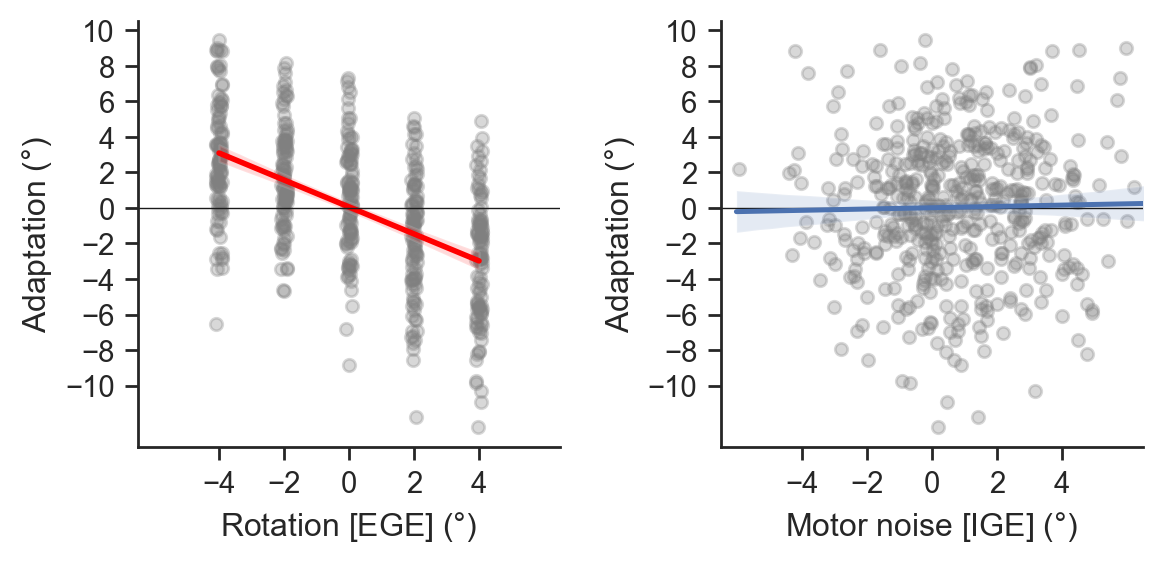

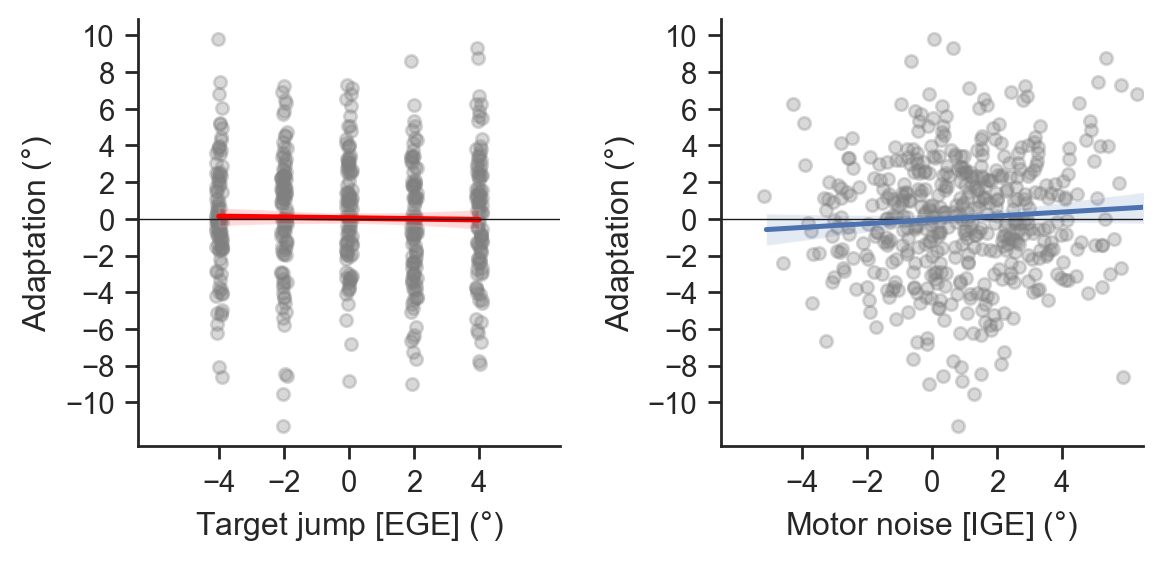

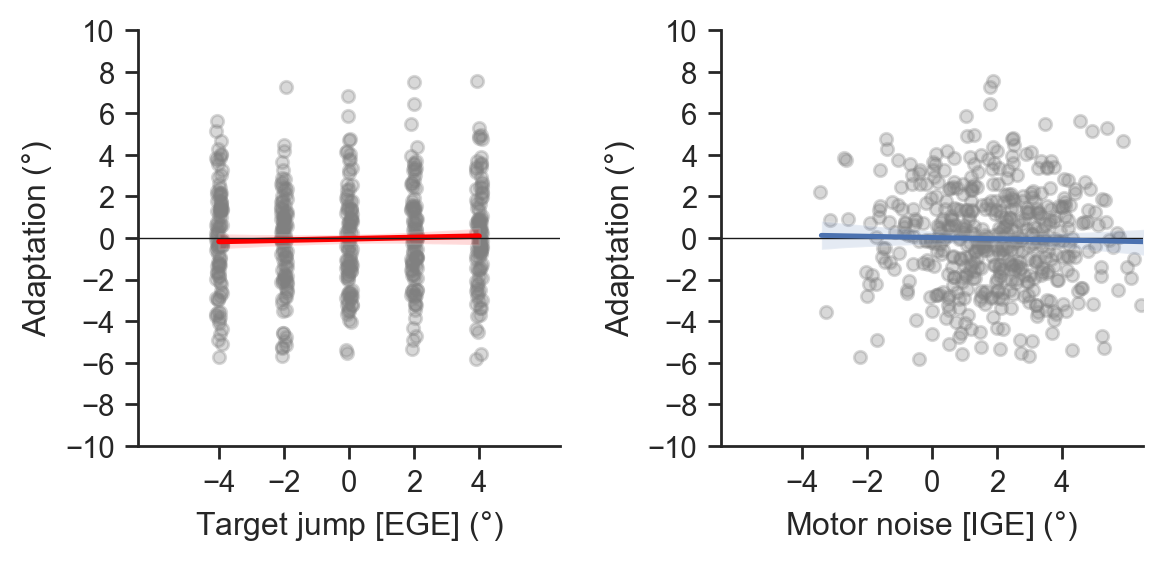

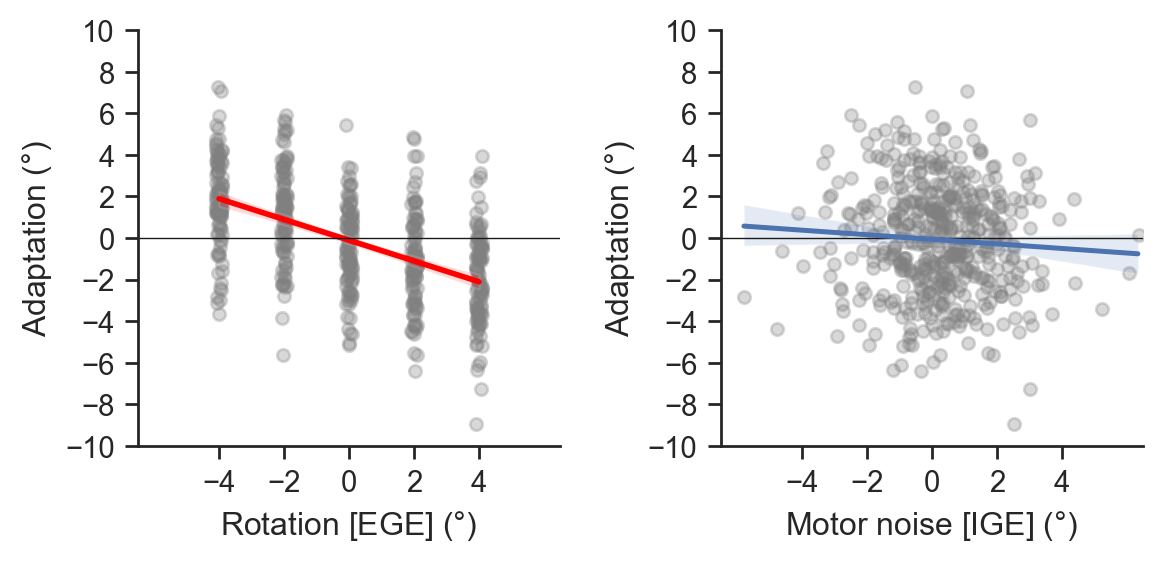

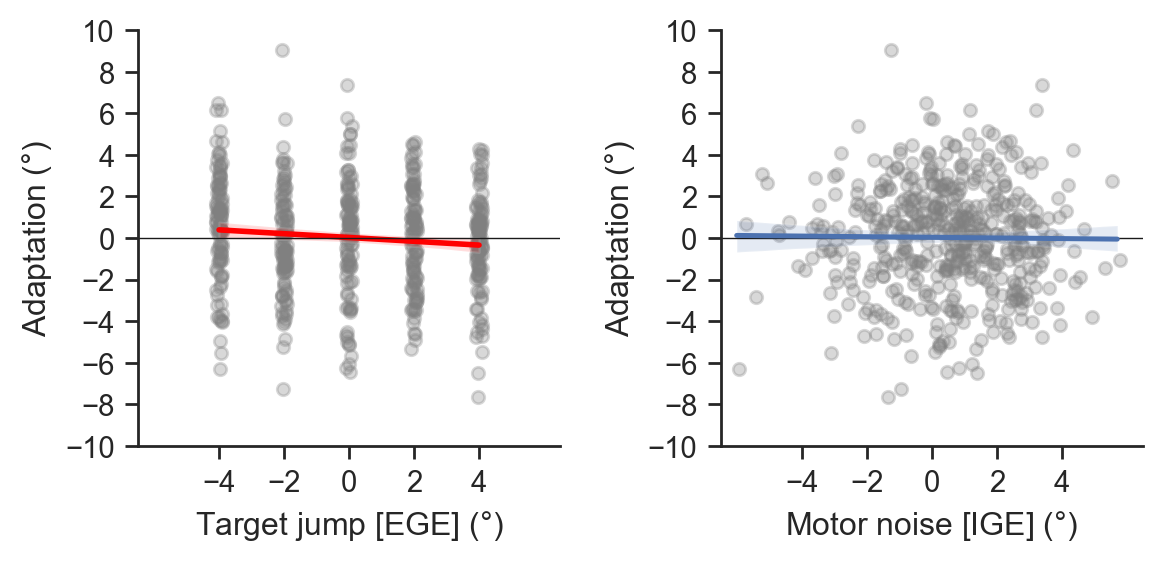

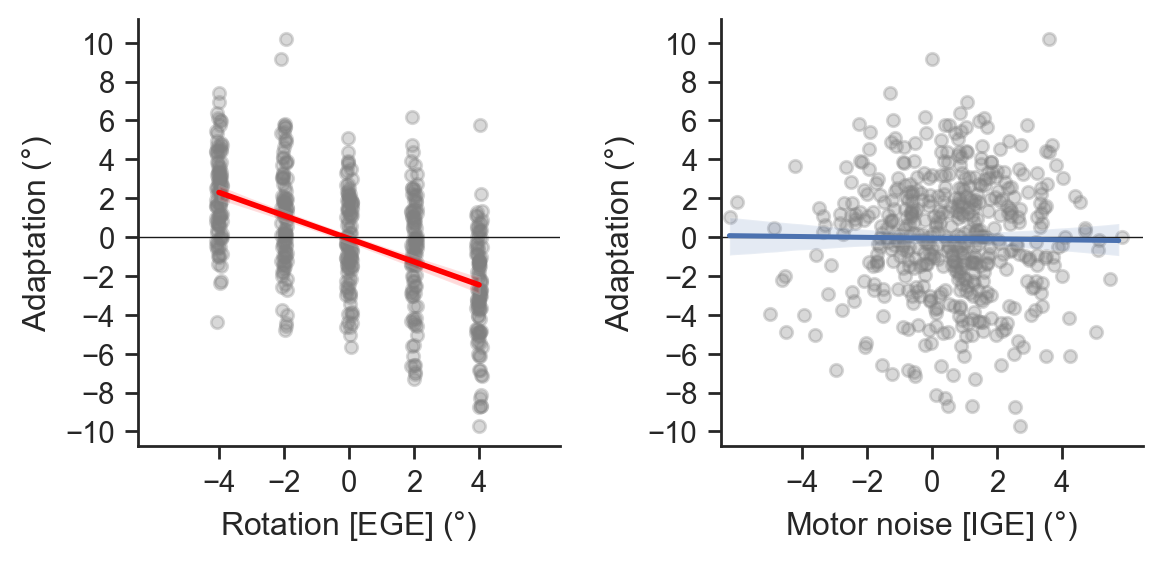

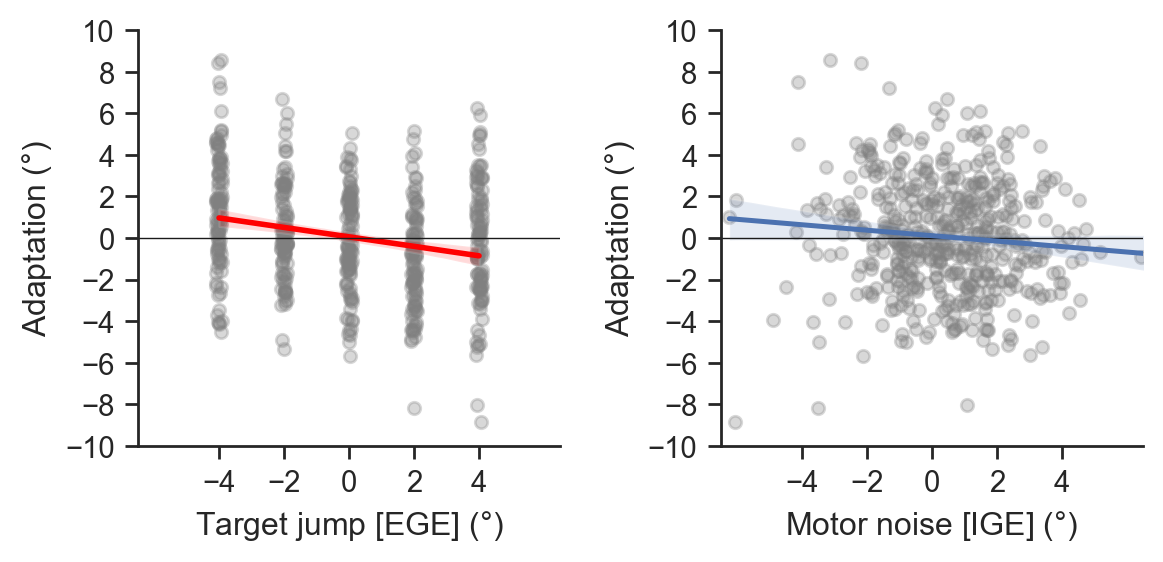

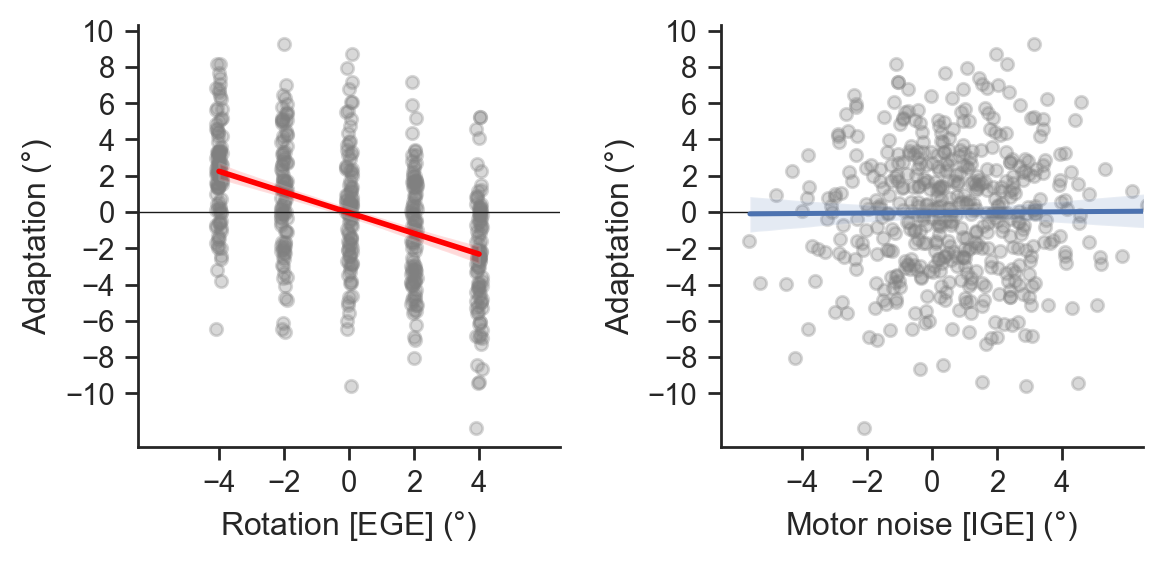

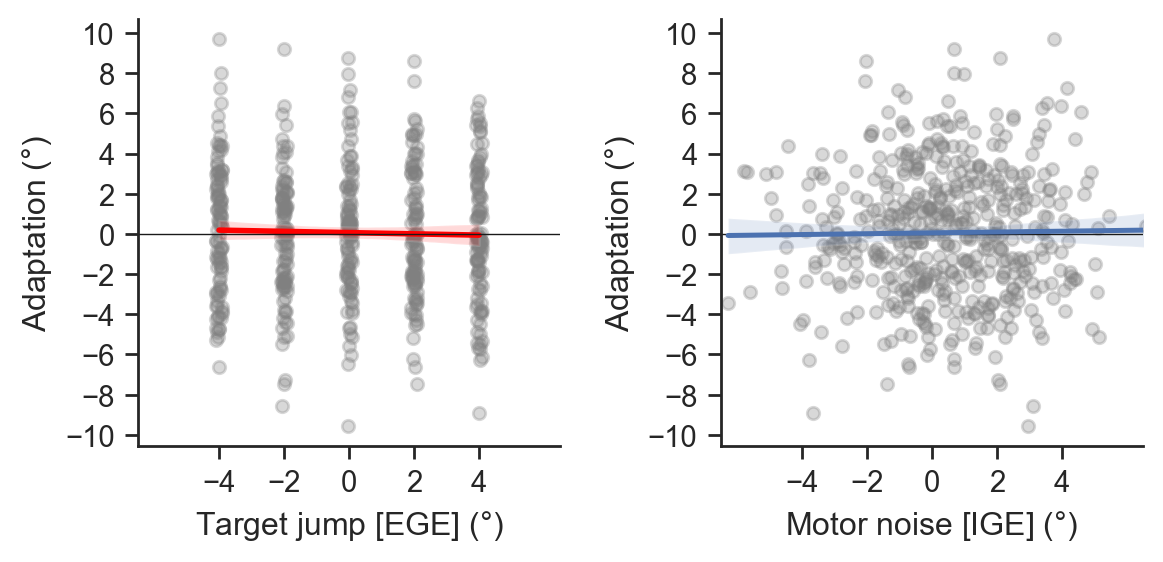

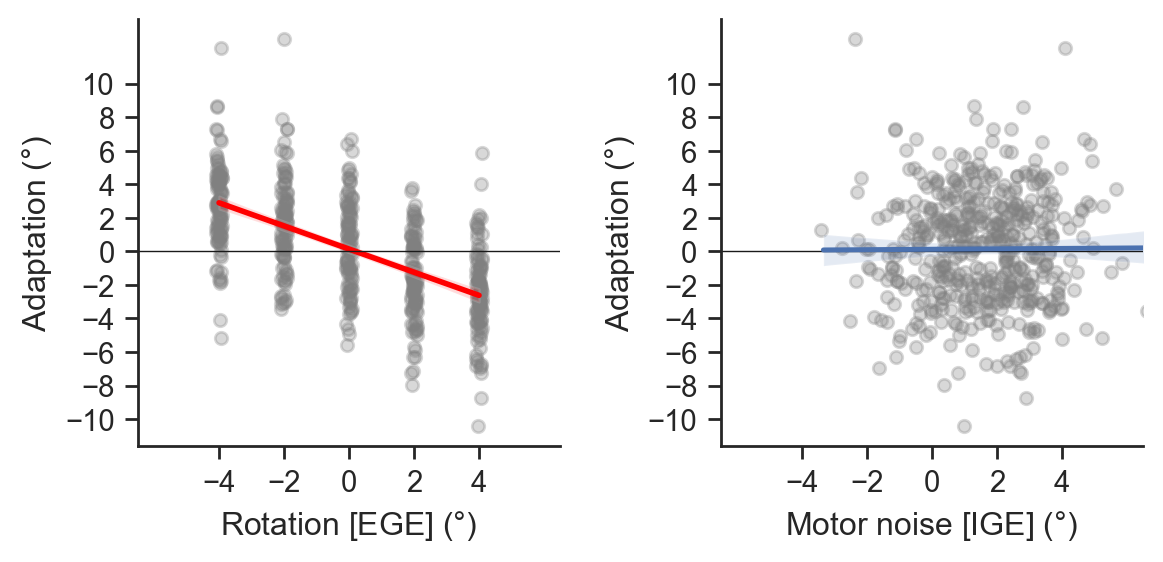

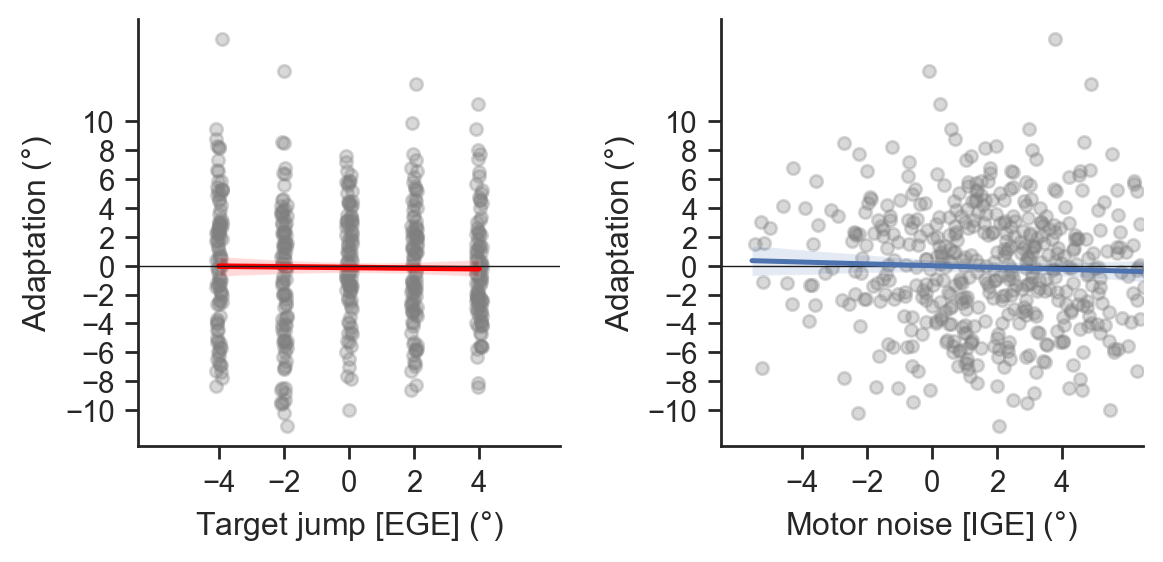

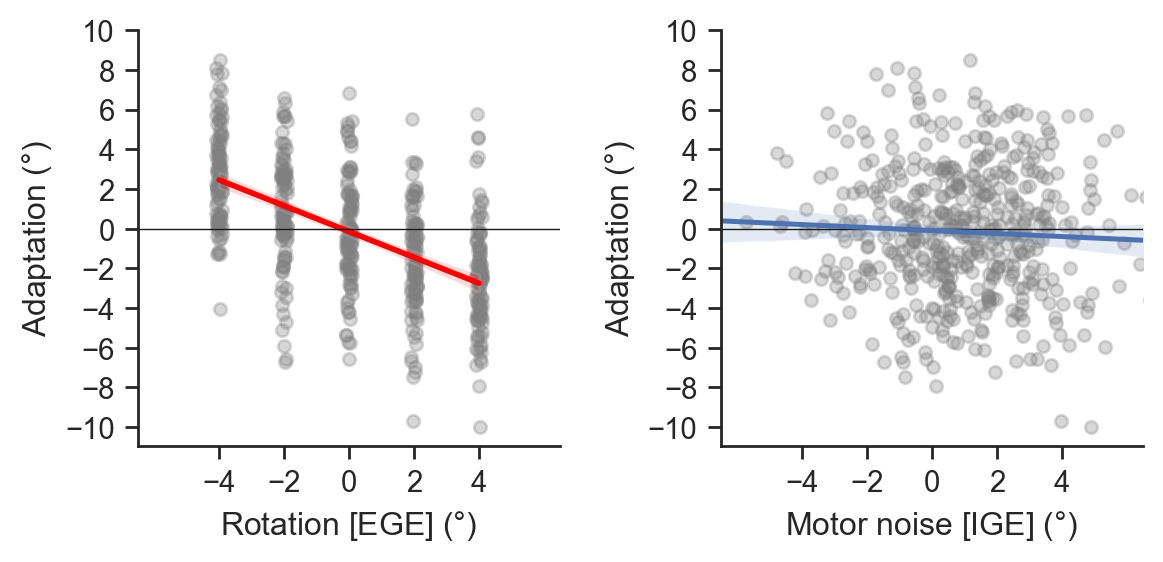

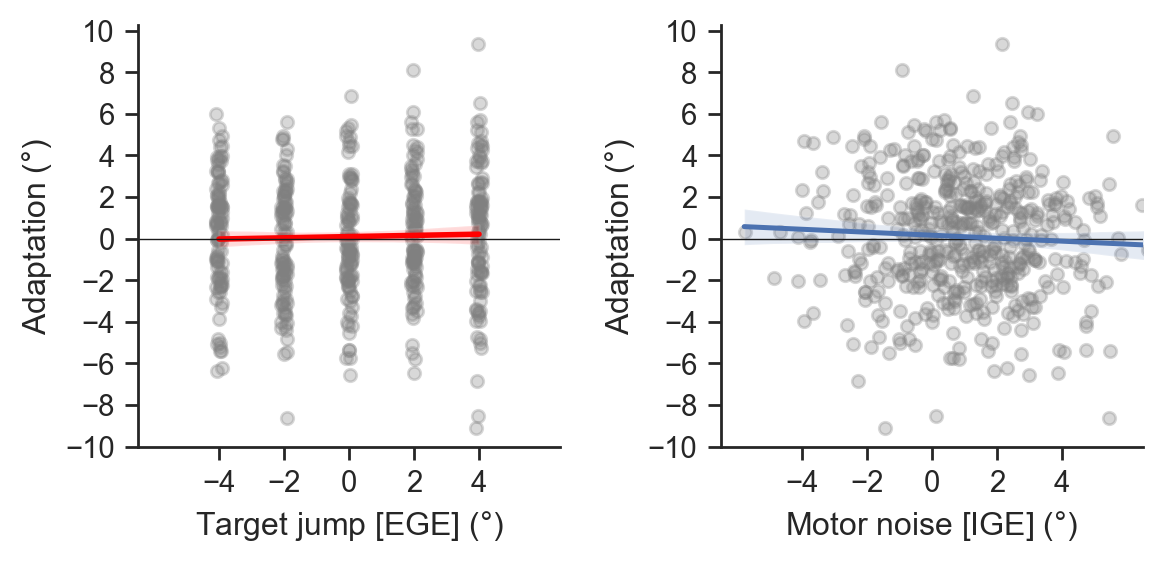

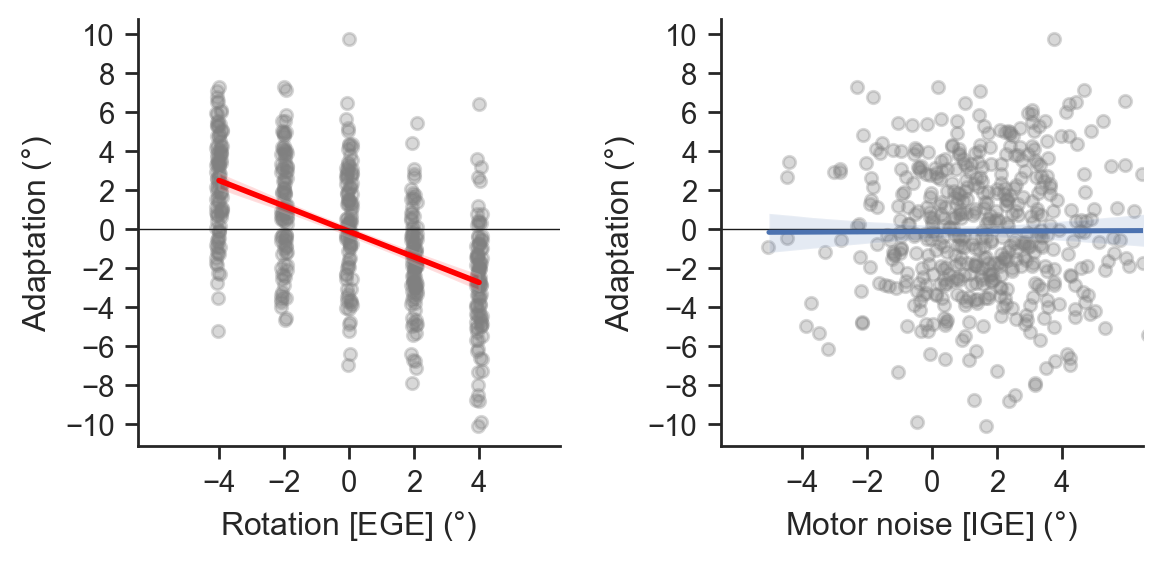

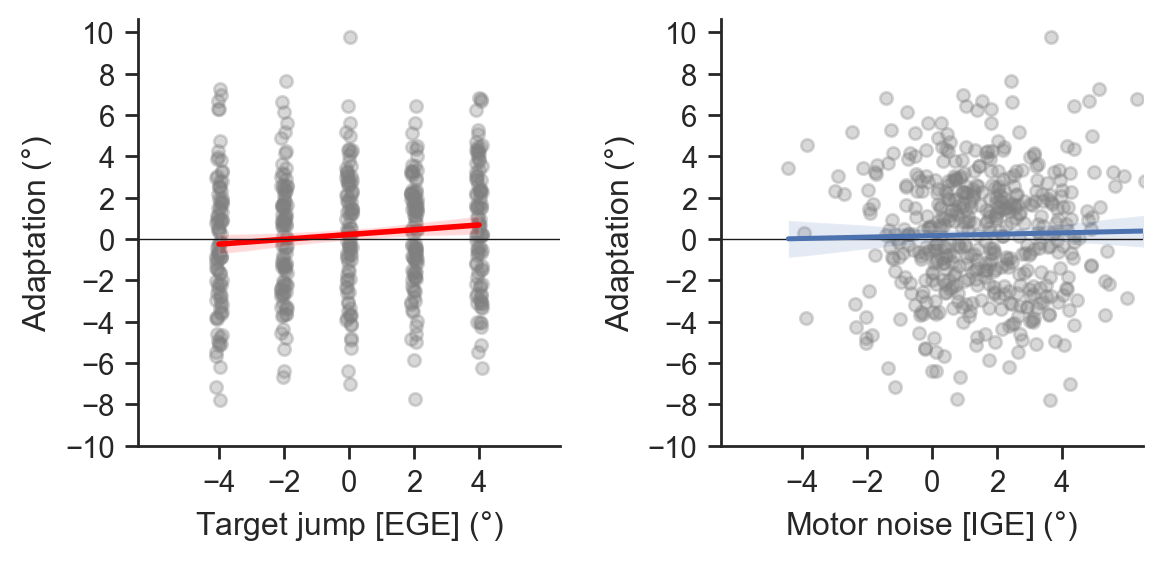

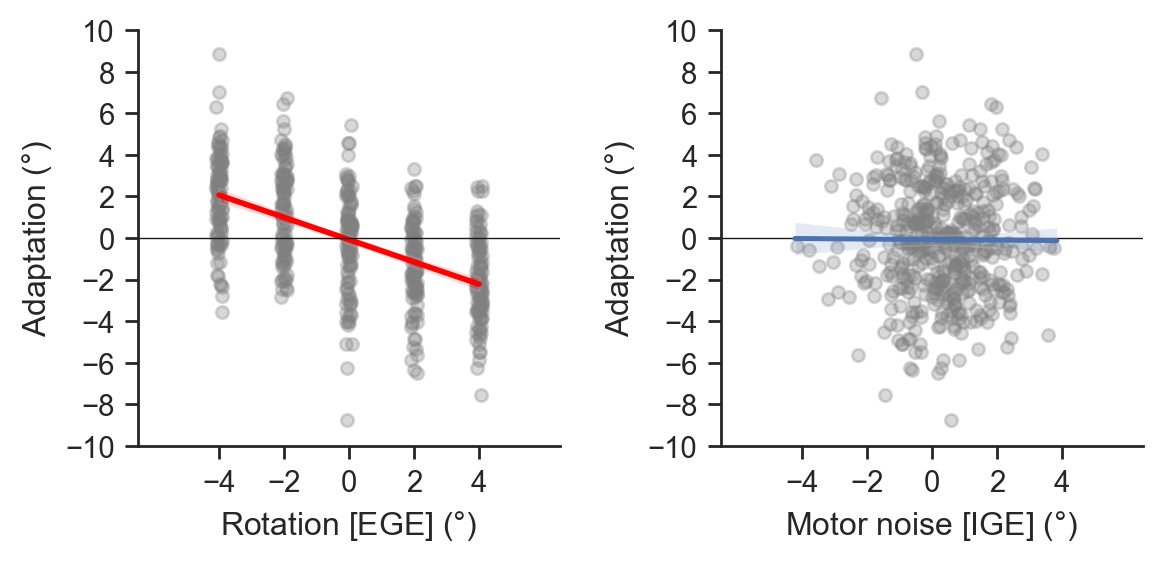

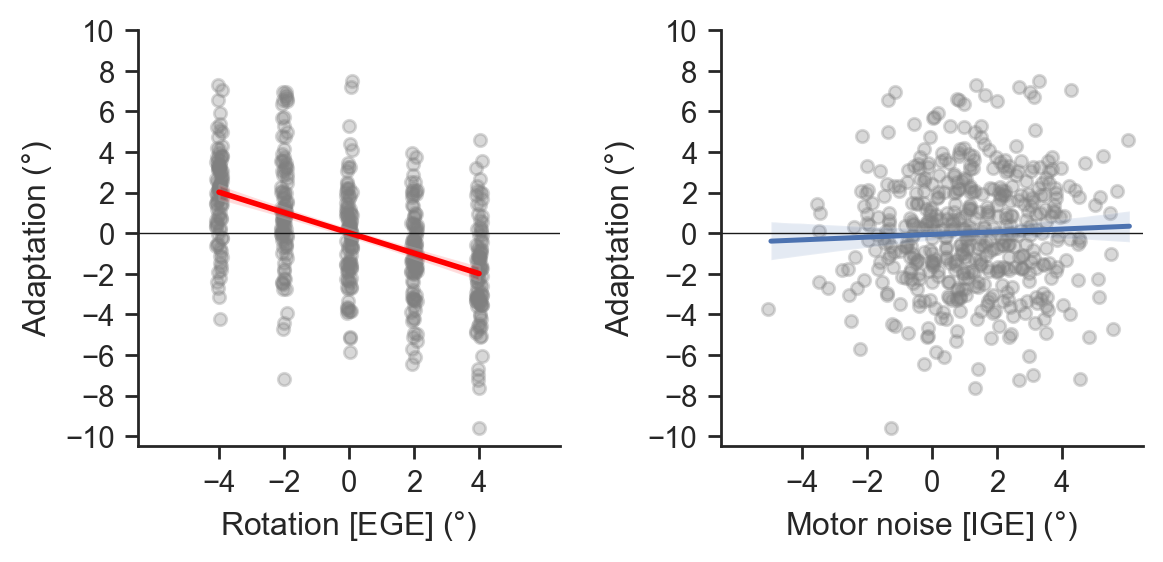

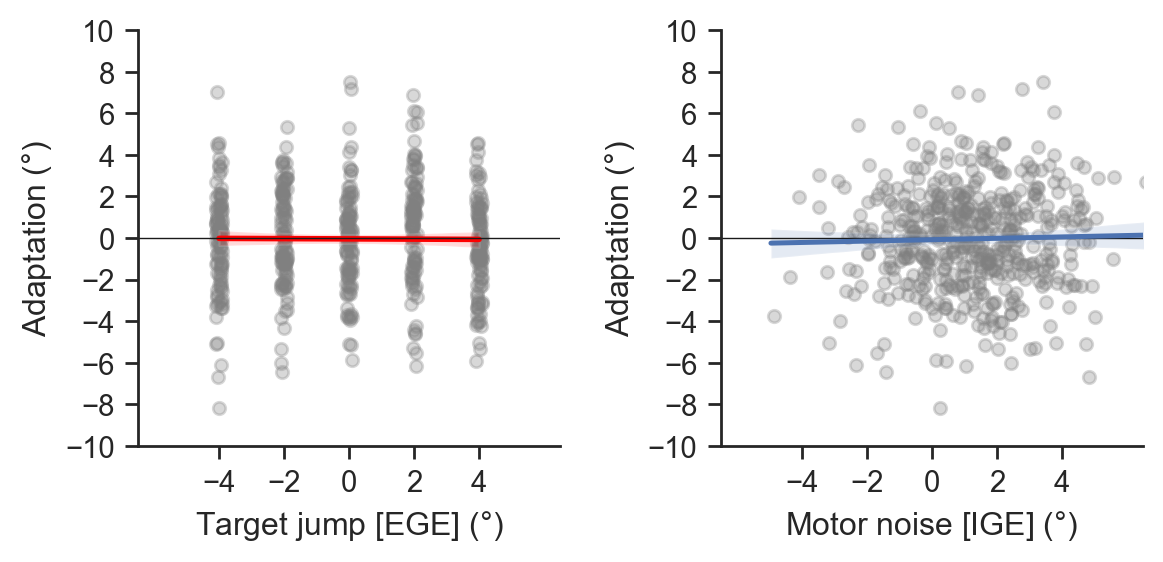

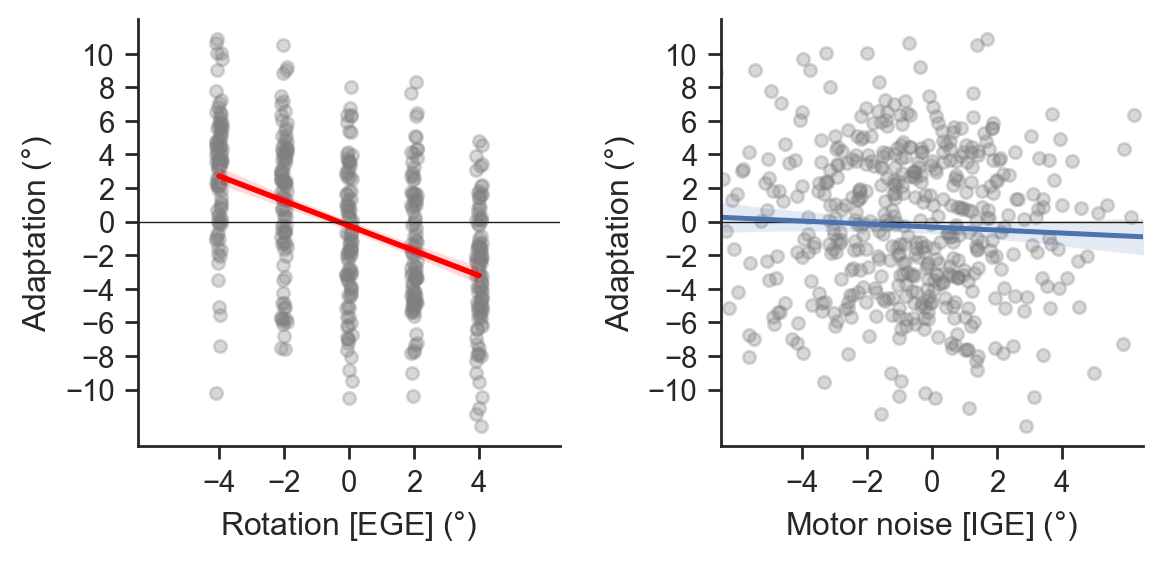

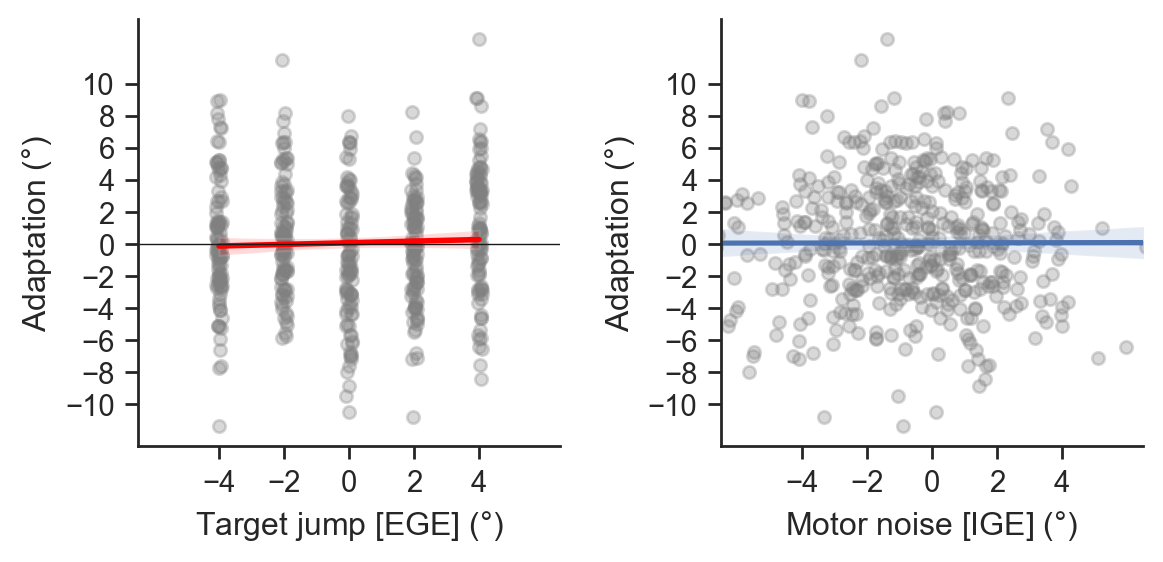

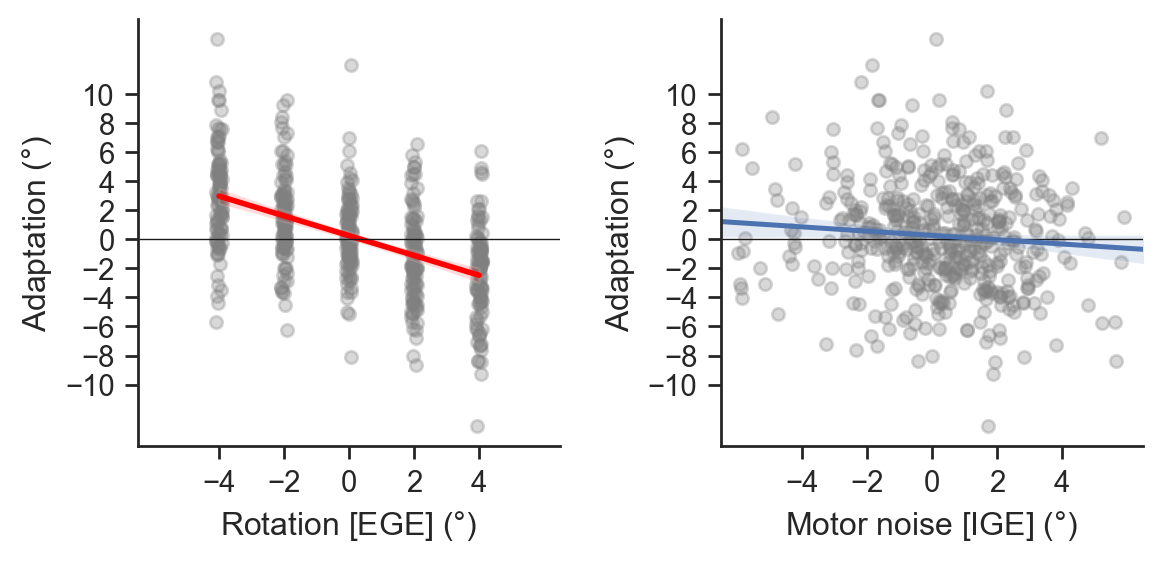

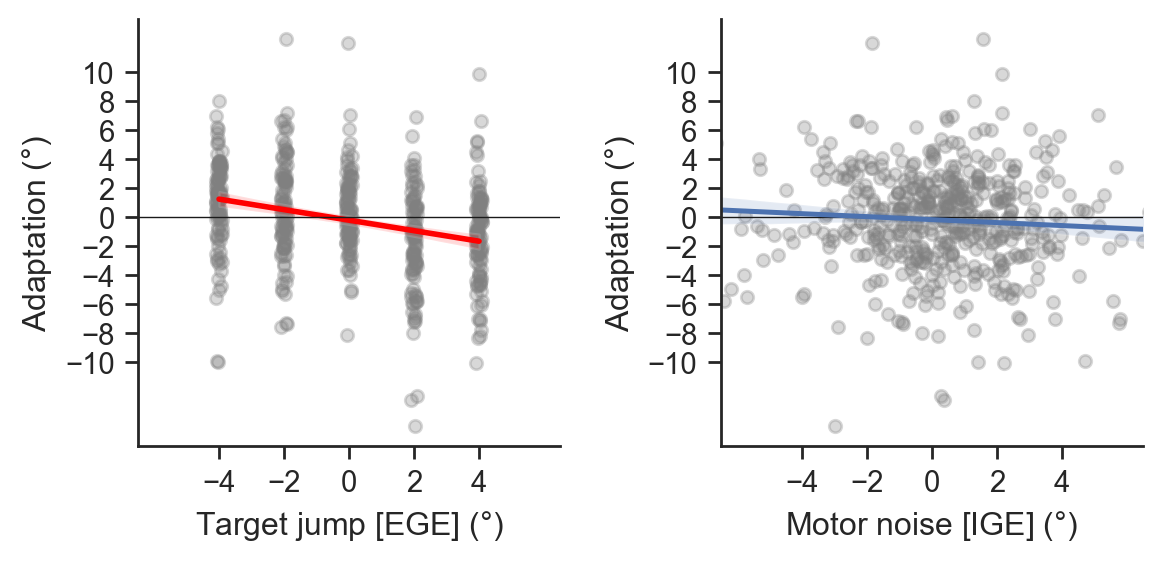

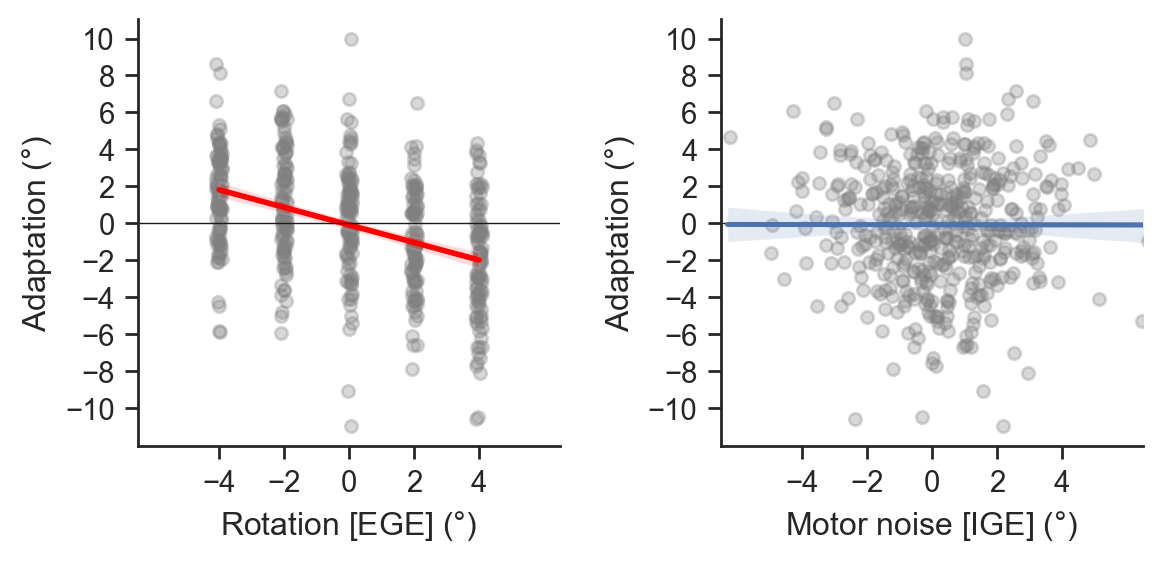

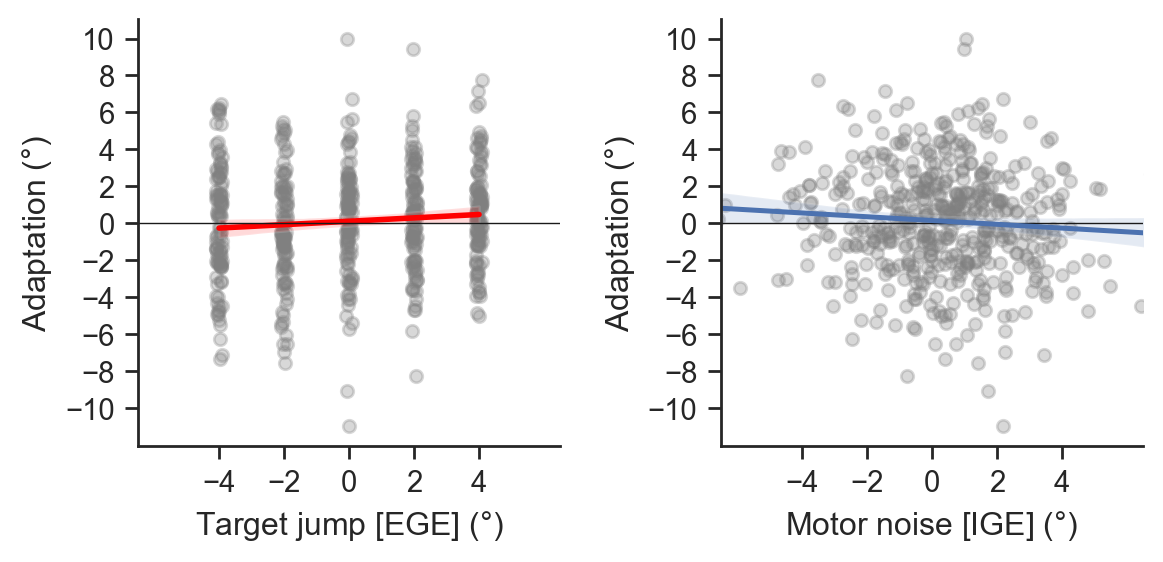

In [8]:
# Choose whether to visualize all data or only adaptation trials preceded by no fb
truncate = False

adapt_rotation = pd.DataFrame()
adapt_jump = pd.DataFrame()
vmr_all = pd.DataFrame()
sigma_motor_bsl = []
sigma_motor_train = []
sigma_v_train = []
beta_rotation_ege = np.zeros(len(df["id"].unique()))
beta_rotation_ige = np.zeros(len(df["id"].unique()))
beta_jump_ege = np.zeros(len(df["id"].unique()))
beta_jump_ige = np.zeros(len(df["id"].unique()))
beta_ext = np.zeros(len(df["id"].unique()))
# Create a new variable for movement extent errors (Change this)
df["extent_err"] = df["hand_max_dist_clean"] - 90

for k, s in enumerate(df["id"].unique()):
    # Create subject-specific data frame
    subj = df[df["id"] == s].reset_index(drop=True)
    
    # Calculate baseline variability
    sigma_motor_bsl.append(subj.loc[20:70, "theta_maxradv_clean"].std())
    
    # Create truncated data frame without baseline trials
    training_start = 70
    subj_train = subj.iloc[training_start - 1:, :].reset_index(drop=True)
    pert_idx = np.arange(1, len(subj_train), 2)
    
    # Loop through trials to get adaptation index
    for i in np.arange(1, len(subj_train), 2):
        subj_train.loc[i, "adaptation"] = subj_train.loc[i + 1, "theta_maxradv_clean"] - subj_train.loc[i - 1, "theta_maxradv_clean"] 
        subj_train.loc[i, "total error"] = subj_train.loc[i, "theta_maxradv_clean"] + subj_train.loc[i, "rotation"]
        # Measure IGE adaptation to movement extent errors
        subj_train.loc[i, "adaptation_ext"] = subj_train.loc[i + 1, "extent_err"] - subj_train.loc[i - 1, "extent_err"]
    
    # Calculate motor and vis fb variability during training
    sigma_motor_train.append(subj_train["theta_maxradv_clean"].std())
    vis_fb_idx = subj_train["fbi"] == 1
    sigma_v_train.append(subj_train.loc[vis_fb_idx, "total error"].std())

    # Dataframes for perturbation trials only (trim null trials)
    subj_adapt = subj_train.loc[pert_idx, :].reset_index()
    subj_adapt["tgt_error"] = subj_adapt["tgt_jump"] * -1
    
    # Pick out trials preceded by no-feedback null trial w/boolean mask
    nofb_idx = np.zeros(len(subj_train), dtype=bool)
    nofb_idx[1:] = subj_train.loc[0:len(subj_train) - 2, "fbi"] == 0  # .loc slicing includes start and stop index
    
    # Insert zero at start of array to index pert trials with preceding no-fb trial
    nofb_triplet_idx = nofb_idx
    subj_adapt_nofb = subj_train.loc[nofb_triplet_idx, :].reset_index()
    subj_adapt_nofb["tgt_error"] = subj_adapt_nofb["tgt_jump"] * -1
    
    # Create separate vmr and target jump data frames
    vmr = subj_adapt.loc[subj_adapt["tgt_jump"] == 0, :]  # Includes 0d rotation
    vmr_nofb = subj_adapt_nofb.loc[subj_adapt_nofb["tgt_jump"] == 0, :]
    mask_jump = (subj_adapt["tgt_jump"] != 0) | ((subj_adapt["tgt_jump"] == 0) & (subj_adapt["rotation"] == 0))
    mask_jump_nofb = (subj_adapt_nofb["tgt_jump"] != 0) | ((subj_adapt_nofb["tgt_jump"] == 0) & (subj_adapt_nofb["rotation"] == 0))
    jump = subj_adapt[mask_jump]
    jump_nofb = subj_adapt_nofb[mask_jump_nofb]
    
    # Concatenate individual subject data frames
    adapt_rotation = pd.concat([adapt_rotation, vmr], ignore_index=True)
    adapt_jump = pd.concat([adapt_jump, jump], ignore_index=True)
    
    # Assign correct data frame for visualization
    if truncate == True:
        df_vmr = vmr_nofb.copy()
        df_jump = jump_nofb.copy()
    else:
        df_vmr = vmr.copy()
        df_jump = jump.copy()
    
    # Plot data for adapt vs vmr-ege
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    sns.regplot(data=df_vmr, x="rotation", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=20), 
               line_kws=dict(linewidth=2, color='red'), ci=95, ax=ax1)
    ax1.axhline(0, c="k", linewidth=0.5)
    ax2.axhline(0, c="k", linewidth=0.5)
    ax1.set(xticks=np.unique(df_vmr["rotation"]), xlabel="Rotation [EGE] ($\degree$)", 
            xlim=(-6.5, 6.5), yticks=np.arange(-10, 10.01, 2), ylabel="Adaptation ($\degree$)")
    sns.despine()
    
    # Plot data for adapt vs ige
    sns.regplot(data=df_vmr, x="theta_maxradv_clean", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=20), ci=95, ax=ax2)
    ax2.set(xticks=np.unique(df_vmr["rotation"]), xlabel="Motor noise [IGE] ($\degree$)", 
        xlim=(-6.5, 6.5), yticks=np.arange(-10, 10.01, 2), ylabel="Adaptation ($\degree$)")
    sns.despine()
    plt.tight_layout()
    
    # Save individual data fig and print out linear regression res
    if k == 12:
        # Get rid of all rows with NaNs in either adaptation or hand cols
        df_vmr = df_vmr.dropna(subset=["adaptation", "theta_maxradv_clean"])
    
        fig.savefig("images/s13.pdf", dpi=300)
        slope_ege, _, _, _, _ = stats.linregress(x=df_vmr["rotation"], y=df_vmr["adaptation"])
        slope_ige, _, _, _, _ = stats.linregress(x=df_vmr["theta_maxradv_clean"], y=df_vmr["adaptation"])
        print(f"The slope for EGE is {slope_ege:.3f}; IGE is {slope_ige:.3f}.")

    # Plot data for adapt vs tgt_jump-ege
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
    sns.regplot(data=df_jump, x="tgt_error", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=20), 
               line_kws=dict(linewidth=2, color='red'), ci=95, ax=ax1)
    ax1.axhline(0, c="k", linewidth=0.5)
    ax2.axhline(0, c="k", linewidth=0.5)
    ax1.set(xticks=np.unique(df_jump["tgt_error"]), xlabel="Target jump [EGE] ($\degree$)", 
            xlim=(-6.5, 6.5), yticks=np.arange(-10, 10.01, 2), ylabel="Adaptation ($\degree$)")
    sns.despine()
    
    # Plot data for adapt vs tgt_jump-ige
    sns.regplot(data=df_jump, x="theta_maxradv_clean", y="adaptation", x_jitter=0.1, 
               scatter_kws=dict(alpha=0.3, color='gray', s=20), ci=95, ax=ax2)
    ax2.set(xticks=np.unique(df_jump["tgt_error"]), xlabel="Motor noise [IGE] ($\degree$)", 
        xlim=(-6.5, 6.5), yticks=np.arange(-10, 10.01, 2), ylabel="Adaptation ($\degree$)")
    sns.despine()
    plt.tight_layout()

    # # Plot data for adapt_ext vs extent_err
    # fig, ax = plt.subplots(figsize=(3, 3))
    # sns.regplot(data=subj_adapt, x="extent_err", y="adaptation_ext", x_jitter=0.1, 
    #             scatter_kws=dict(alpha=0.3, color="gray", s=20), ci=95, ax=ax)

    # # Plot RTs and MTs
    # fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True, layout="tight")
    # ax[0].hist(subj_train["RT"], alpha=0.5, bins=12)
    # ax[0].set(xlabel="RT (s)", ylabel="Count", xlim=[0, 2])
    # ax[1].hist(subj_train["MT"], alpha=0.5, bins=12)
    # ax[1].set(xlabel="MT (s)", xlim=[0, 0.8])
    # sns.despine()
    # plt.show()
    
    # Some simple frequentist statistics
    data1 = pd.DataFrame({
        'ege': vmr["rotation"], 
        'ige': vmr["theta_maxradv_clean"],
        'adapt': vmr["adaptation"]
    })
    
    data2 = pd.DataFrame({
        "ege": jump["tgt_error"],
        "ige": jump["theta_maxradv_clean"],
        "adapt": jump["adaptation"]
    })

    # data3 = pd.DataFrame({
    #     "extent_err": subj_adapt["extent_err"],
    #     "adapt_ext": subj_adapt["adaptation_ext"]
    # })

    # Fit the regression models
    model_vmr = ols("adapt ~ ege + ige - 1", data1).fit()
    model_jump = ols("adapt ~ ege + ige - 1", data2).fit()
    # model_ext = ols("adapt_ext ~ extent_err - 1", data3).fit()
    beta_rotation_ege[k] = model_vmr._results.params[0]
    beta_rotation_ige[k] = model_vmr._results.params[1]
    beta_jump_ege[k] = model_jump._results.params[0]
    beta_jump_ige[k] = model_jump._results.params[1]
    # beta_ext[k] = model_ext._results.params[0]
    
    # Export each subject's VMR data and putting into data frame
    idx_rotation = (
        (subj_train["rotation"] != 0) 
        & (subj_train["tgt_jump"] == 0)
    ) # Non-zero rotation trials

    idx_zero = (
        (subj_train["rotation"] == 0) 
        & (subj_train["tgt_jump"] == 0) 
        & (subj_train.index.values % 2 == 1)  # null trials  
    ) # Zero deg "rotation" trials

    idx_combined = idx_rotation | idx_zero
    subj_train["perturbation"] = idx_combined
    subj_train["motor_sd"] = sigma_motor_bsl[-1]
    indices = np.flatnonzero(idx_combined)
    indices = np.sort(np.unique(np.concatenate((indices - 1, indices, indices + 1))))
    vmr_all = pd.concat([vmr_all, subj_train.loc[indices, :]], ignore_index=True)

    # # Add column to indicate perturbation trials
    # s10["perturbation"] = idx_combined

vmr_all.to_csv("../results/vmr_all.csv", index=False)

---
## Wrangle data into binned and truncated formats

In [9]:
# Process data to create 5x5 IGE/EGE plots. Binning based on IGE.
adapt_rotation["ige_quintile"] = adapt_rotation.groupby(["SN", "rotation"])["theta_maxradv_clean"].transform(
    lambda x: pd.qcut(x, 5, labels=range(1, 6)))
adapt_jump["ige_quintile"] = adapt_jump.groupby(["SN", "tgt_error"])["theta_maxradv_clean"].transform(
    lambda x: pd.qcut(x, 5, labels=range(1, 6)))
rotation_binned = adapt_rotation.groupby(["SN", "rotation", "ige_quintile"])[["theta_maxradv_clean", "adaptation"]].mean().reset_index()
jump_binned = adapt_jump.groupby(["SN", "tgt_error", "ige_quintile"])[["theta_maxradv_clean", "adaptation"]].mean().reset_index()

In [10]:
# For each individual, regress 25 bins onto IGE/EGE (include col of IGE values)
beta_binned_vmr = np.zeros(16)
beta_binned_vmr_ige = np.zeros(16)
beta_binned_jump = np.zeros(16)
beta_binned_jump_ige = np.zeros(16)

for idx, val in enumerate(rotation_binned["SN"].unique()):
    subj_rot = rotation_binned.loc[rotation_binned["SN"] == val, :]
    subj_jump = jump_binned.loc[jump_binned["SN"] == val, :]
    
    model_vmr = ols("adaptation ~ rotation - 1", subj_rot).fit()
    model_vmr_ige = ols("adaptation ~ theta_maxradv_clean - 1", subj_rot).fit()
    model_jump = ols("adaptation ~ tgt_error - 1", subj_jump).fit()
    model_jump_ige = ols("adaptation ~ theta_maxradv_clean -1", subj_jump).fit()

    beta_binned_vmr[idx] = model_vmr._results.params
    beta_binned_vmr_ige[idx] = model_vmr_ige._results.params
    beta_binned_jump[idx] = model_jump._results.params
    beta_binned_jump_ige[idx] = model_jump_ige._results.params

beta_binned_vmr = (beta_binned_vmr,)
beta_binned_vmr_ige = (beta_binned_vmr_ige,)
beta_binned_jump = (beta_binned_jump,)
beta_binned_jump_ige = (beta_binned_jump_ige,)

res_vmr = bootstrap(beta_binned_vmr, np.mean, method="percentile").confidence_interval
res_vmr_ige = bootstrap(beta_binned_vmr_ige, np.mean, method="percentile").confidence_interval
res_jump = bootstrap(beta_binned_jump, np.mean, method="percentile").confidence_interval
res_jump_ige = bootstrap(beta_binned_jump_ige, np.mean, method="percentile").confidence_interval

print(f"95\% CI for VMR-EGE: {res_vmr}")
print(f"95\% CI for VMR-IGE: {res_vmr_ige}")
print(f"95\% CI for Jump-EGE: {res_jump}")
print(f"95\% CI for Jump-IGE: {res_jump_ige}")

95\% CI for VMR-EGE: ConfidenceInterval(low=-0.6463458452950958, high=-0.5490211646178593)
95\% CI for VMR-IGE: ConfidenceInterval(low=-0.07045268354189319, high=-7.01666069215147e-05)
95\% CI for Jump-EGE: ConfidenceInterval(low=-0.09011246026851114, high=0.026972013631129416)
95\% CI for Jump-IGE: ConfidenceInterval(low=-0.054884617494507376, high=0.015066328613214084)


In [11]:
# Create data frames for population-averaged Adapt vs IGE/EGE. "as_index"
# argument flattens dataframe, instead of keeping hierarchical indexing
popn_rotation = rotation_binned.groupby(
    ["rotation", "ige_quintile"], as_index=False).mean().drop(columns="SN")  
popn_jump = jump_binned.groupby(
    ["tgt_error", "ige_quintile"], as_index=False).mean().drop(columns="SN")
popn_jump

tgt_error ige_quintile  theta_maxradv_clean  adaptation
0          -4            1            -2.195981    0.234288
1          -4            2            -0.238812    0.171434
2          -4            3             0.769174    0.482426
3          -4            4             1.830239    0.445267
4          -4            5             3.566211    0.036461
5          -2            1            -1.864341   -0.212974
6          -2            2            -0.156219    0.102881
7          -2            3             0.890654    0.490223
8          -2            4             1.961382   -0.429641
9          -2            5             3.610370   -0.258495
10          0            1            -2.053968    0.115052
11          0            2            -0.169453   -0.024604
12          0            3             0.861334    0.157849
13          0            4             1.891875   -0.019701
14          0            5             3.558945   -0.199834
15          2            1            -2.034265   -0.118366
16          2            2            -0.230041   -0.132818
17          2            3             0.856696   -0.316057
18          2            4             1.871297   -0.254297
19          2            5             3.629603   -0.203013
20          4            1            -2.150860    0.045714
21          4            2            -0.241697    0.388617
22          4            3             0.743380    0.132123
23          4            4             1.749749   -0.000923
24          4            5             3.500501   -0.200361

In [12]:
# Put regression coeffs into data frame
n = len(beta_rotation_ege)
subj_num = np.linspace(1, len(beta_rotation_ege), len(beta_rotation_ege), n)
df_betas = pd.DataFrame({
    "subject":subj_num, 
    "EGE": np.repeat("EGE", n),
    "IGE": np.repeat("IGE", n),
    "beta_rotation_ege":beta_rotation_ege * -1, 
    "beta_rotation_ige":beta_rotation_ige * -1,
    "beta_jump_ege":beta_jump_ege * -1,
    "beta_jump_ige":beta_jump_ige * -1
})

# Compute means of betas
-(beta_rotation_ege).mean()

# Compute 95% CIs 
bootstrap((-beta_rotation_ege,), np.mean, method="percentile").confidence_interval
bootstrap((-beta_rotation_ige,), np.mean, method="percentile").confidence_interval
bootstrap((-beta_jump_ege,), np.mean, method="percentile").confidence_interval
bootstrap((-beta_jump_ige,), np.mean, method="percentile").confidence_interval


ConfidenceInterval(low=-0.008820153358870476, high=0.05305522133751396)

---
## Plotting functions and figures

In [13]:
def plot_coeffs(ax, data, y1, y2):
    sns.pointplot(data=data, x="EGE", y=y1, ax=ax, c="r")
    sns.stripplot(data=data, x="EGE", y=y1, alpha=0.3, ax=ax, c="r")
    sns.pointplot(data=data, x="IGE", y=y2, ax=ax, c="b")
    sns.stripplot(data=data, x="IGE", y=y2, alpha=0.3, ax=ax, c="b")
    ax.axhline(linewidth=0.5, color="k")
    plt.tight_layout()
    return ax

def set_labels(fig, ax, title=None):
    ax.set(xlabel="", ylabel=r"$\beta$ (sensitivity)", title=title, ylim=(-0.25, 0.85))
    sns.despine()
    
def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_theme(context="paper", font_scale=1.2)
    sns.set_style("ticks")


def plot_binned_data(binned_data, popn_data, ege_col, beta_ege_col, beta_ige_col):
    '''
    Group-level figure showing relationships between adaptation and IGE/EGE.
    '''

    # Set-up color cycles
    colors_ige = plt.get_cmap("Blues")(np.linspace(0.2, 0.8, 5))
    colors_ege = plt.get_cmap("Reds")(np.linspace(0.2, 0.8, 5))
    
    # Plot adaptive response vs IGE and EGE for rotation trials
    perts = np.unique(binned_data[ege_col])
    pert = []
    x_mean_ige = np.zeros(5)
    x_err_ige = np.zeros(5)
    y_mean_ige = np.zeros(5)
    y_err_ige = np.zeros(5)
    x_mean_ege = np.zeros(5)
    x_err_ege = np.zeros(5)
    y_mean_ege = np.zeros(5)
    y_err_ege = np.zeros(5)
    h = np.zeros(len(perts), dtype=int)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 2.75), width_ratios=[3, 3, 1])
    for i in range(len(perts)):
        idx = binned_data[ege_col] == perts[i]
        pert = pd.DataFrame(binned_data.loc[idx, :])
        pert["ige_mean"] = np.nan
        for j in range(5):
            idx_bin = pert["ige_quintile"] == j + 1
            temp = pert.loc[idx_bin, :]
            x_mean_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].mean()
            x_err_ige[j] = pert.loc[idx_bin, "theta_maxradv_clean"].sem()
            y_mean_ige[j] = pert.loc[idx_bin, "adaptation"].mean()
            y_err_ige[j] = pert.loc[idx_bin, "adaptation"].sem()
            pert.loc[idx_bin, "ige_mean"] = pert.loc[idx_bin, "theta_maxradv_clean"].mean()
            ax2.errorbar(x=x_mean_ige[j], y=y_mean_ige[j], yerr=y_err_ige[j], ecolor=colors_ege[i],
                     **{"marker":"o", "markeredgecolor":colors_ege[i], "markerfacecolor":colors_ige[j], "linestyle":"none"}) 
            ax2.set_xticks((-4, -2, 0, 2, 4))
        sns.regplot(data=pert, x="ige_mean", y="adaptation", ax=ax2, ci=0, 
                    scatter=False, scatter_kws={"color":colors_ege[i]}, 
                    line_kws={"color":colors_ege[i], "linewidth":1})
    # Plot overall correlation and compute statistics, bootstrapped CIs
    sns.regplot(data=popn_data, x="theta_maxradv_clean", y="adaptation", ax=ax2,
                scatter=False, ci=None, line_kws={"color":"k", "linestyle":"--"})
    slope_ige, _, r_ige, p_ige, std_err_ige = stats.linregress(
        popn_data["theta_maxradv_clean"], popn_data["adaptation"])
    ax2.text(-4, 3.5, f"$r^2$={r_ige**2:.3f}", fontsize="small")
    ax2.text(-4, 3.0, f"$slope=${slope_ige:.3f}", fontsize="small")
    
    # Outer loop is for ige bins, inner loop for pert levels
    for i in range(5):
        idx = binned_data["ige_quintile"] == i + 1
        binned = pd.DataFrame(binned_data.loc[idx, :])
        for j in range(5):
            idx_ege = binned[ege_col] == perts[j]
            x_mean_ege[j] = binned.loc[idx_ege, ege_col].mean()
            x_err_ege[j] = binned.loc[idx_ege, ege_col].sem()
            y_mean_ege[j] = binned.loc[idx_ege, "adaptation"].mean()
            y_err_ege[j] = binned.loc[idx_ege, "adaptation"].sem()
            binned.loc[idx_ege, "ege_mean"] = binned.loc[idx_ege, ege_col].mean()
            ax1.errorbar(x=x_mean_ege[j], y=y_mean_ege[j], yerr=y_err_ege[j], ecolor=colors_ege[i],
                    **{"marker":"o", "markeredgecolor":colors_ege[j], "markerfacecolor":colors_ige[i], "linestyle":"none"})
            ax1.set_xticks((-4, -2, 0, 2, 4))
        sns.regplot(data=binned, x="ege_mean", y="adaptation", ax=ax1, ci=0,
                    scatter=False, line_kws={"color":colors_ige[i], "linewidth":1})
    sns.regplot(data=popn_data, x=ege_col, y="adaptation", ax=ax1,
                scatter=False, ci=None, line_kws={"color":"k", "linestyle":"--"})
    # Plot overall correlation and compute statistics, bootstrapped CIs
    r_ege, p_ege = sp.stats.pearsonr(popn_data[ege_col], popn_rotation["adaptation"])
    slope_ege, _, r_ege, p_ege, std_err_ege = stats.linregress(
        popn_data[ege_col], popn_data["adaptation"])
    ax1.text(-4, -1.5, f"$r^2$={r_ege**2:.3f}", fontsize="small")
    ax1.text(-4, -2.0, f"$slope=${slope_ege:.3f}", fontsize="small")
    
    # More figure aesthetics    
    ax1.set(xlabel="Externally-generated error ($\degree$)", ylabel="Adaptation ($\degree$)", xlim=[-4.5, 4.5], ylim=[-4, 4])
    sns.despine()
    ax2.set(xlabel="Internally-generated error ($\degree$)", ylabel="Adaptation ($\degree$)", xlim=[-4.5, 4.5], ylim=[-4, 4])
    plt.tight_layout()
    
    ax3 = plot_coeffs(ax3, df_betas, df_betas[beta_ege_col], df_betas[beta_ige_col])
    set_labels(fig, ax3)
    ax3.tick_params(axis="x", labelrotation=45)
    plt.tight_layout()

    return fig

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_67419/4283985036.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_67419/4283985036.py:104: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_67419/4283985036.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/42/fy648srd41l966jbjlswhljc0000gr/T/ipykernel_67419/4283985036.py:104: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


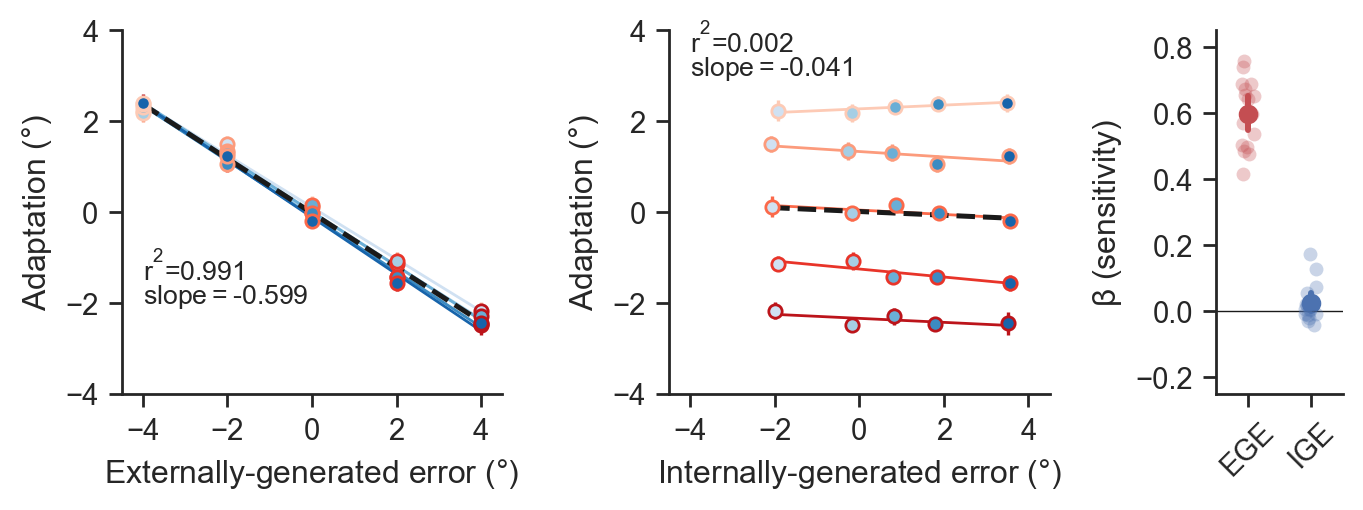

In [14]:
# Plot binned data
fig_rotation = plot_binned_data(rotation_binned, popn_rotation, "rotation", "beta_rotation_ege", "beta_rotation_ige")
fig_jump = plot_binned_data(jump_binned, popn_jump, "tgt_error", "beta_jump_ege", "beta_jump_ige")

# Save figs
fig_rotation.savefig("images/binned-data-rotation.pdf", dpi=300)
fig_jump.savefig("images/binned-data-tgtjump.pdf", dpi=300)

# Correlation results of population-averaged (binned) data
r_ege_vmr, p_ege_vmr = sp.stats.pearsonr(popn_rotation["rotation"], popn_rotation["adaptation"])
r_ige_vmr, p_ige_vmr = sp.stats.pearsonr(popn_rotation["theta_maxradv_clean"], popn_rotation["adaptation"])
r_ege_jump, p_ege_jump = sp.stats.pearsonr(popn_jump["tgt_error"], popn_jump["adaptation"])
r_ige_jump, p_ige_jump = sp.stats.pearsonr(popn_jump["theta_maxradv_clean"], popn_jump["adaptation"])

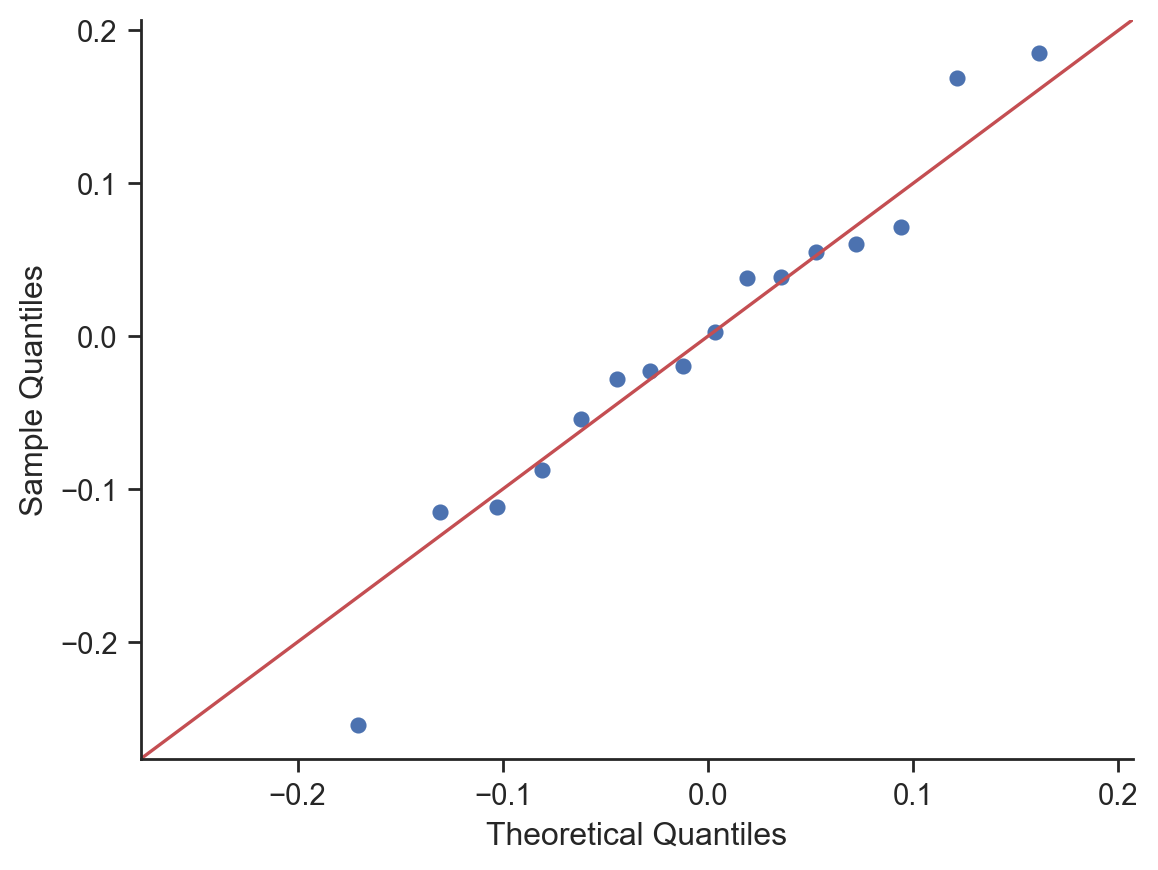

TtestResult(statistic=-18.295225820072574, pvalue=1.1425297981189234e-11, df=15)
TtestResult(statistic=-18.295225820072574, pvalue=1.1425297981189234e-11, df=15) ConfidenceInterval(low=-0.6409947616717738, high=-0.5072238010023801)
TtestResult(statistic=-0.16642956601818326, pvalue=0.8700415708531389, df=15) ConfidenceInterval(low=-0.06289298767470312, high=0.05378262795947688)


In [15]:
# Check difference scores of betas for normality
diff_scores_vmr = beta_rotation_ege - beta_rotation_ige
sm.qqplot(diff_scores_vmr, loc=diff_scores_vmr.mean(), scale=diff_scores_vmr.std(), line='45')
plt.show()

diff_scores_jump = beta_jump_ege - beta_jump_ige
sm.qqplot(diff_scores_jump, loc=diff_scores_jump.mean(), scale=diff_scores_jump.std(), line='45')
plt.show()

# Compute t-test on betas
print(stats.ttest_rel(beta_rotation_ege, beta_rotation_ige))
res_vmr = stats.ttest_1samp(diff_scores_vmr, popmean=0)
ci_vmr = res_vmr.confidence_interval(confidence_level=0.95)
print(res_vmr, ci_vmr)

res_jump = stats.ttest_1samp(diff_scores_jump, popmean=0)
ci_jump = res_jump.confidence_interval(confidence_level=0.95)
print(res_jump, ci_jump)

In [16]:
# Median RTs
df.groupby("SN")[["RT", "MT"]].median().reset_index()

SN        RT        MT
0    1  0.298796  0.348188
1    2  0.188650  0.407778
2    3  0.263357  0.395820
3    4  0.292485  0.348560
4    5  0.265221  0.347797
5    6  0.312687  0.347825
6    7  0.305482  0.343391
7    8  0.267925  0.403415
8    9  0.264692  0.301220
9   10  0.305340  0.330330
10  11  0.365746  0.405981
11  12  0.299037  0.372272
12  13  0.286644  0.315394
13  14  0.300454  0.329873
14  15  0.214426  0.426745
15  16  0.278154  0.409867

---
## Miscellaneous

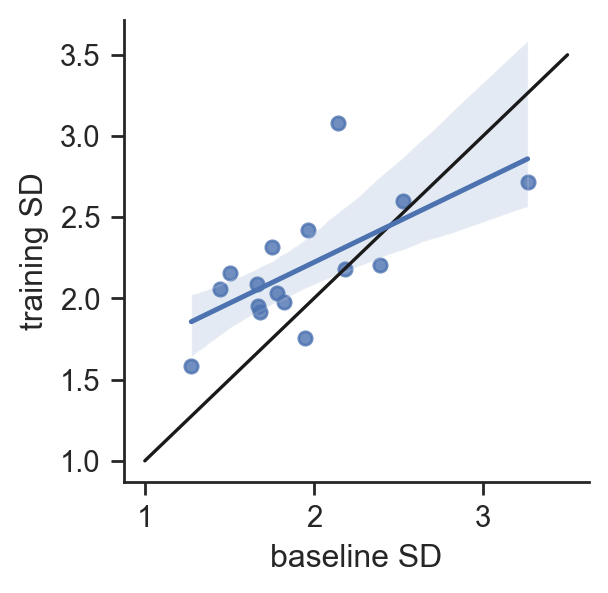

In [17]:
# Check if motor variability increases during perturbation block
var = pd.DataFrame({
    "sigma_motor_bsl":sigma_motor_bsl, 
    "sigma_motor_train":sigma_motor_train, 
    "sigma_v_train":sigma_v_train
})

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot([1, 3.5], [1, 3.5], "k")
sns.regplot(data=var, x=sigma_motor_bsl, y=sigma_motor_train, ax=ax)
ax.set(xlabel="baseline SD", ylabel="training SD")
sns.despine()
plt.show()